In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
import time
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable


In [4]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

In [5]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

In [6]:
validation_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

In [7]:
root = 'C:/Users/ENES DORUK/Desktop/CNN_Harf/Dataset'

train_data = datasets.ImageFolder(os.path.join(root,'training_set'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test_set'), transform=test_transform)
valid_data = datasets.ImageFolder(os.path.join(root,'validation_set'),  transform=validation_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=30, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data, batch_size=30,pin_memory=True)
valid_loader =  DataLoader(valid_data, batch_size=30,pin_memory=True)

dataset_sizes = len(train_data)

class_names = train_data.classes

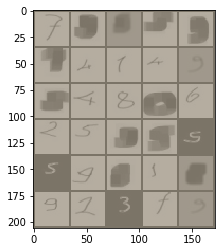

In [8]:
for images, labels in train_loader:
    break
im = make_grid(images,nrow=5)
inv_normalize = transforms.Normalize(
        mean= [-0.485/0.225,
              -0.456/0.224,
              -0.406/0.225],
        std= [1/0.225, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2))
        
        
        self.fc1 = nn.Linear(1152, 84)
        self.fc2 = nn.Linear(1152, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.softmax(self.fc1(out))
        out = F.softmax(self.fc2(out))
        return out
        

from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)


In [15]:
epochs = 1000
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [16]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [18]:
import torchvision
train_loss = []
correct_graph = []

def train(cnn):
    start = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for epoch in range(epochs): 
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 50)
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = cnn(inputs)
            total += labels.size(0)
            predicted = torch.max(outputs.data, 1)[1]
            loss = criterion(outputs, labels)
            correct += (predicted == labels).sum().item()
            correct_graph.append((predicted == labels).sum().item())
            train_loss.append(loss.item())
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if i % 100 == 99:   
                print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
                tb.add_scalar('training loss',
                                running_loss / 1000,
                                epoch * len(train_loader) + i)

               
                grid = torchvision.utils.make_grid(inputs)
                tb.add_image("images", grid)
                tb.add_graph(cnn, inputs)
                tb.add_scalar("Loss", running_loss, epoch)
                tb.add_scalar("Correct", correct,epoch)
                tb.add_scalar("Accuracy", correct/len(train_data), epoch)
                
                running_loss = 0.0
        
            if epoch % 10 == 0:
                torch.save(cnn.state_dict(), 'C:/Users/ENES DORUK/Desktop/FaceExpressions/savemodel/model_{}.pth'.format(epoch))
                print("Loss", loss.item())
                print("Correct", correct)
    end = time.time()
    

    print('Done Training')
    print('%0.2f minutes' %((end - start) / 60))
    
    return cnn
    
train(cnn)
tb.close()       

Epoch 0/2
--------------------------------------------------
Loss 2.3125712871551514
Correct 4
Loss 2.6771414279937744
Correct 9
Loss 2.2688097953796387
Correct 13
Loss 2.3083136081695557
Correct 17
Loss 2.311171054840088
Correct 20
Loss 2.2970550060272217
Correct 25
Loss 2.3118131160736084
Correct 27
Loss 2.300956964492798
Correct 28
Loss 2.3084490299224854
Correct 30
Loss 2.2966315746307373
Correct 32
Loss 2.305499792098999
Correct 35
Loss 2.2986040115356445
Correct 37
Loss 2.285653591156006
Correct 43
Loss 2.3046658039093018
Correct 47
Loss 2.315021276473999
Correct 51
Loss 2.321826457977295
Correct 51
Loss 2.3117177486419678
Correct 52
Loss 2.305248260498047
Correct 54
Loss 2.2935006618499756
Correct 61
Loss 2.2911295890808105
Correct 69
Loss 2.3062026500701904
Correct 72
Loss 2.303495168685913
Correct 74
Loss 2.2922275066375732
Correct 79
Loss 2.306187391281128
Correct 80
Loss 2.309908866882324
Correct 82
Loss 2.2976319789886475
Correct 87
Loss 2.292548894882202
Correct 92
Loss 2.

Loss 1.2300432920455933
Correct 2088
Loss 1.1757373809814453
Correct 2107
Loss 1.032104253768921
Correct 2126
Loss 1.1669615507125854
Correct 2145
Loss 0.8904941082000732
Correct 2162
Loss 1.0839587450027466
Correct 2182
Loss 0.9515677094459534
Correct 2202
Loss 1.0140910148620605
Correct 2224
Loss 1.7363131046295166
Correct 2241
Loss 0.6962740421295166
Correct 2264
Loss 1.252510905265808
Correct 2281
Loss 1.0250128507614136
Correct 2299
Loss 0.9302073121070862
Correct 2318
Loss 1.086266279220581
Correct 2337
Loss 1.046146035194397
Correct 2357
Loss 1.1554582118988037
Correct 2375
Loss 1.2362209558486938
Correct 2392
Loss 1.1185516119003296
Correct 2411
Loss 0.7755847573280334
Correct 2436
Loss 0.8268689513206482
Correct 2458
Loss 1.0449198484420776
Correct 2478
Loss 1.4823321104049683
Correct 2493
Loss 0.9424235224723816
Correct 2514
Loss 0.7755377888679504
Correct 2535
Loss 0.8836142420768738
Correct 2560
Loss 1.5546624660491943
Correct 2576
Loss 0.9401330351829529
Correct 2597
Loss 

Loss 0.8411813378334045
Correct 6868
Loss 1.1476391553878784
Correct 6888
Loss 0.4329846203327179
Correct 6915
Loss 0.8248713612556458
Correct 6938
Loss 0.6926518678665161
Correct 6960
Loss 0.7153645753860474
Correct 6983
Loss 1.1990574598312378
Correct 7003
Loss 0.610691487789154
Correct 7027
Loss 0.6217796802520752
Correct 7051
Loss 0.39893075823783875
Correct 7078
Loss 0.5236241221427917
Correct 7104
Loss 0.4977826476097107
Correct 7129
Loss 0.9761808514595032
Correct 7152
Loss 0.4088943898677826
Correct 7178
Loss 0.2995012700557709
Correct 7205
Loss 0.5762743353843689
Correct 7230
Loss 0.6773313283920288
Correct 7253
Loss 0.7015684247016907
Correct 7278
Loss 0.7444105744361877
Correct 7302
Loss 0.5613724589347839
Correct 7324
Loss 0.5627850294113159
Correct 7348
Loss 0.6927737593650818
Correct 7371
Loss 0.7077328562736511
Correct 7394
Loss 0.5678373575210571
Correct 7420
Loss 0.9770097136497498
Correct 7443
Loss 0.9248233437538147
Correct 7464
Loss 0.9463755488395691
Correct 7483
L

Loss 0.2856474816799164
Correct 12261
Loss 0.5400857329368591
Correct 12287
Loss 0.2804487645626068
Correct 12312
Loss 0.7455002069473267
Correct 12333
Loss 0.3837529420852661
Correct 12360
Loss 0.6540605425834656
Correct 12384
Loss 1.1627862453460693
Correct 12405
Loss 0.318017840385437
Correct 12433
Loss 0.4210131764411926
Correct 12459
Loss 0.6882871389389038
Correct 12483
Loss 0.3308602571487427
Correct 12509
Loss 0.6136407256126404
Correct 12533
Loss 0.5597439408302307
Correct 12557
Loss 0.5852279663085938
Correct 12582
Loss 0.5832469463348389
Correct 12603
Loss 0.4652777910232544
Correct 12630
Loss 0.7642301321029663
Correct 12656
Loss 0.4972397983074188
Correct 12681
Loss 0.5220061540603638
Correct 12708
Loss 0.3584580719470978
Correct 12734
Loss 0.5585113763809204
Correct 12758
Loss 0.7309865951538086
Correct 12783
Loss 0.7205333709716797
Correct 12806
Loss 0.44623205065727234
Correct 12832
Loss 0.4293791651725769
Correct 12858
Loss 0.2400326430797577
Correct 12887
Loss 0.73292

Loss 0.5018753409385681
Correct 17719
Loss 0.29476678371429443
Correct 17745
Loss 0.3773294687271118
Correct 17772
Loss 0.31508731842041016
Correct 17797
Loss 0.33263295888900757
Correct 17824
Loss 0.34741857647895813
Correct 17850
Loss 0.2902275621891022
Correct 17876
Loss 0.54977947473526
Correct 17902
Loss 0.3642200529575348
Correct 17928
Loss 0.538112461566925
Correct 17953
Loss 1.8899527788162231
Correct 17974
Loss 0.23725776374340057
Correct 17988
Epoch 1/2
--------------------------------------------------
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


KeyboardInterrupt: 

In [ ]:
def test():
    tst_corr = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            tst_corr += correct
            
    loss = criterion(outputs, labels)
    test_loss.append(loss)
    test_correct.append(correct)    
    print('Accuracy of the network on test images: %0.3f %%' % (
        100 * correct / total))
test()

In [ ]:
continued_network = cnn = CNN().to(device)
continued_optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for epoch in range(3):
    train(cnn)
    if(epoch == 3):
        test()

In [ ]:
top = 0
for p in cnn.parameters():
    print(p.numel())
    top += p.numel()
top

In [ ]:
def predict_image(image):
    image_tensor = test_transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = cnn(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    
    class_names = train_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
to_pil = transforms.ToPILImage()
class_names = train_data.classes
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(class_names[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
import cv2
cap = cv2.VideoCapture('C:/Users/ENES DORUK/Desktop/FaceExpressions/ifade.mp4')


if (cap.isOpened()== False): 
   print("Error Video File")

while(cap.isOpened()):
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 48)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 48)
    ret, frame = cap.read()
    height, width = frame.shape[:2]
    

    if ret == True:
        dim = (48, 48)
        resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
        image = to_pil(resized)
        index = predict_image(image)
        font = cv2.FONT_HERSHEY_SIMPLEX
        org = (100, 200) 
        fontScale = 3
        color = (255, 0, 0) 
        thickness = 7
       
        image = cv2.putText(frame, '{}'.format(index), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
        
            
        cv2.imshow('Frame',frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else: 
        break

cap.release()
cv2.destroyAllWindows()
